In [ ]:
import numpy as np  
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Exercises

As you work on these, you may re-use or modify any of the code above. You are welcome to work in groups, though each student should turn in an individual notebook with answers by uploading to this [Google Drive folder](https://drive.google.com/drive/folders/1Tf99kycwrvAFJ_D7stayd8RkrWOXEds1).  

1. In the previous simulation, we found that as we increase epsilon, that is, as agents become more exploratory, performance always increases. Do you think this will be the case for ranges of epsilon in which the agent almost always explores? Why or why not? Modify the simulation script above to verify your intuition. If you found that the answer is no, at what value of epsilon do we start noticing diminishing returns of exploration?  

2. In lecture, we learned that another way to encourage exploration is by allowing agents to start with optimistic initial values. Check that this is the case by comparing the performance of a wildly optimistic agent that starts with $Q_t = 5$ and greedily selects actions, to that of a realistic agent which explores randomly with probability $ϵ = 0.1$ (hint, see plot from lecture). 

3. Modify the agent's policy to add uncertainty-driven exploration using the UCB algorithm from lecture. How does the agent's performance change as a function of the $c$ parameter? 

4. Modify the Environment class to implement the 4-armed bandit task described in [Addicott et al. (2017)](https://www.nature.com/articles/npp2017108). Confirm by visualizing the reward structure.



# Question 1: 
No, because if an agent explores too much (very high epsilon) an agent will not exploit higher reward arms. Diminishing returns findings below: 


Defining the environment class:


In [ ]:
class Environment(object):
  
  """Class for the multiarmed bandit environment.

  Parameters
  ----------
  k : int
      Number of arms.
  mu : array, float, shape(k, )
      Mean for each arm.
  sigma : array, float, shape(k, )
      Standard deviation for each arm. 

  """

  def __init__(self, k, mu, sigma):

    """Constructor for the Environment class
    This function runs every time we create an instance of the class Environment
    To learn more about how constructors work: https://www.udacity.com/blog/2021/11/__init__-in-python-an-overview.html"""

    # "self" is just a convention that binds the attributes and methods of a class with the arguments of a given instance

    self.k = k          # number of arms
    self.mu = mu        # mean of reward distribution for each arm
    self.sigma = sigma  # standard deviation of reward distribution for each arm
    self.t = 0          # initialize timestep
    
    if self.mu.shape[0] is not k:
      raise Warning("Mean vector shape does not match number of arms")

    if self.sigma.shape[0] is not k:
      raise Warning("Sigma vector shape does not match number of arms")

  def visualize(self, style):

    # this method lets us visualize the structure of the environment
    # in the multiarmed bandit case, this consists of the reward distribution for each arm 

    # visualize as Gaussian densities
    if style == 1:
      
      x = np.arange(-5, 5, 0.001)

      for i in np.arange(self.k):
        plt.plot(x, norm.pdf(x, self.mu[i], self.sigma[i]), label='μ: ' + str(self.mu[i]) + ', σ: ' + str(self.sigma[i]))

      plt.legend()
      plt.xlabel('Reward distribution')
      plt.ylabel('Density')

    # draw many samples from each distribution and plot histograms
    if style == 2: 

      # initialize output list 
      bandit = []   # which bandit we're drawing from
      samples = []  # samples we drew

      # iterate over each bandit
      for i in np.arange(self.k):
        
        n_samples = 1000

        # create bandit index
        b = list(np.ones((n_samples, )) * (i+1))

        # draw samples
        s = list(np.random.normal(self.mu[i], self.sigma[i], n_samples))
  
        # add to lists  
        bandit = bandit + b
        samples = samples + s

      # create pandas dataframe from dictionary
      # background on dictionaries: https://www.w3schools.com/python/python_dictionaries.asp
      # background on dataframes: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html 
      df = pd.DataFrame({'bandit': list(map(int, bandit)), 
                         'samples': samples})
      
      # use seaborn to plot distributions
      # background on seaborn: https://seaborn.pydata.org/index.html
      sns.violinplot(data=df, x="bandit", y="samples")
      
      plt.xlabel('Action')
      plt.ylabel('Reward distribution')

  def step(self, action):

    # the step method takes as input an action and changes the environment
    # in the bandit case, the environment responds with a reward

     # draw reward
    reward = np.random.normal(self.mu[action-1], self.sigma[action-1], 1)[0]

    # increment timestep
    self.t = self.t + 1

    # comment the next line in if you want to print the time step
    # print('timestep: ' + str(self.t))

    return reward

Testing environment


In [ ]:
#going to use same bandit
# Initialize a 10-armed bandit where each arm has an increasing mean and standard deviation of 1
n_arms = 10
means = np.arange(n_arms)-5
sds = np.ones((n_arms,))

# This line creates an instance of the class we defined above with some attributes
env = Environment(n_arms, means, sds)

print(means)
print(sds)


[-5 -4 -3 -2 -1  0  1  2  3  4]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Defining agent with higher epsilon (more exploratory)

In [ ]:
class Agent(object):
  """Class for the e-greedy agent.

  Parameters
  ----------
  epsilon : float, range (0, 1)
      Epsilon probability of exploration.

  """

  def __init__(self, env, epsilon, q_init=False):

    # initialize action space
    self.action_space = np.arange(env.k) + 1

    # initialize parameters
    self.eps = epsilon
    
    # initialize Q-values and action counters
    if q_init: # check if initial q-values were provided 
      # self.q = q_init #this doesnt work because you haven't made it a list
      self.q = np.ones((env.k, ))*q_init   
    else:   
      self.q = np.zeros((env.k, ))
    
    # initialize action counter
    self.action_counter = np.zeros((env.k, ))  

  def policy(self):

    # for now, you can think of the policy method as encoding how 
    # an agent selects actions.
    # in the epsilon-greedy case, the agent has an internal representation
    # of the value of each action. its policy is to pick the action with the 
    # highest value with probability 1-epsilon and explore a random action with 
    # probabilty epsilon.  

    # generate random number between 0 and 1.
    # this draws from a uniform distribution, so we have an equal probability
    # of generating any real number between 0 and 1.
    p = np.random.rand()

    # select action
    if (p < self.eps): # is the number we drew is smaller than epsilon? 
      action = np.random.choice(env.k)+1 # random action
    else: 
      action = np.argmax(self.q)+1 # action with highest q-value     
    
    return action

  def update(self, action, reward, verbose=False):

    # the update method encodes how the agent learns from its actions. 
    # it takes as input the action and reward.
  
    # update action counter
    self.action_counter[action-1] = self.action_counter[action-1] + 1

    # update value of selected action in proportion to the difference between the 
    # current reward and the previous value, times a step size 
    # equal to the inverse of how many times the agent selected that action in the past.
    # in other words, the step size will be smaller the more we select that action. 
    self.q[action-1] = self.q[action-1] + 1/self.action_counter[action-1] * (reward - self.q[action-1])

    if verbose == True: 
      print(self.q)

Simulation

In [ ]:
def run_simulation(n_timesteps, params, verbose=False):

  """Function for running one simulation of the bandit problem.
  It specifies how the environment and agent interact over the course
  of multiple timesteps.

  Parameters
  ----------

  n_timesteps: int
      How many timesteps to run the simulation for

  params : dictionary containing parameters of the simulation 

      Environment parameters
      n_arms: int
        Number of arms.
      means: array, float, shape(n_arms, )
        Means for each arm.
      sds: array, float, shape(n_arms, )
        Standard deviations for each arm.
      
      Agent parameters
      epsilon: float, range (0, 1)
        Epsilon probability of exploration.

  verbose: flag for printing some output

  Returns
  ----------

  sim_output: dictionary containing simulation output

      actions: array, int, shape(n_timesteps, )
        Action that the agent took on each timestep.

      rewards: array, float, shape(n_timesteps, )
        Rewards that the agent received on each timestep.

      optimal_action: array, boolean, shape(n_timestep, )
        Indicator vector that tells us if the agent took the best possible action.
  """

  # make environment (10-arm testbed with varying means and same standard deviation)
  env = Environment(params['n_arms'], params['means'], params['sds'])

  # initialize agent 
  agent = Agent(env, params['epsilon'])

  # initialize output lists
  A = [] # action taken at each timestep
  R = [] # rewards on each timestep
  OA = [] # was the optimal action taken at each timestep? 

  # loop for given number of timesteps
  for t in np.arange(n_timesteps):

    # agent selects action
    action = agent.policy()

    # environment responds with a reward
    reward = env.step(action)

    # record action and reward
    A.append(action)
    R.append(reward)

    # record whether the agent took the optimal action
    optimal_action = np.argmax(params['means'])+1
    OA.append(action == optimal_action)
    
    if verbose: 
      print('action: ' + str(action))
      print('reward: ' + str(reward))

    agent.update(action, reward, verbose=False)

  # record output in dictionary
  sim_output = {
      'timestep': np.arange(n_timesteps)+1,
      'actions': np.array(A),
      'rewards': np.array(R),
      'optimal_action': np.array(OA)
  }

  return env, agent, sim_output

In [ ]:
# Run simulation many times for different values of epsilon
n_runs = 2000

# Initialize output list
D = []

#changing epsilon to be greater than 0.1  
for e in [0.2, 0.5, .7, 1]:

  print('epsilon = '  + str(e))

  for r in np.arange(n_runs): 

    print('simulation #: ' + str(r+1))

    n_timesteps = 1000
    params = {
      'n_arms': 10,
      'means': np.array([0.5, -0.9, 1.5, 0.7, 1.3, -1.5, -0.3, -1, 0.9, -0.7]),
      'sds': np.ones((n_arms,)) * 0.5,
      'epsilon': e 
    }

    _, _, sim_output = run_simulation(n_timesteps, params)

    # convert to dataframe and append to list
    d = pd.DataFrame(sim_output)
    d.insert(0, 'run', r+1)
    d.insert(1, 'epsilon', e)
    D.append(d)

data = pd.concat(D, ignore_index=True)

Streaming output truncated to the last 5000 lines.
simulation #: 1003
simulation #: 1004
simulation #: 1005
simulation #: 1006
simulation #: 1007
simulation #: 1008
simulation #: 1009
simulation #: 1010
simulation #: 1011
simulation #: 1012
simulation #: 1013
simulation #: 1014
simulation #: 1015
simulation #: 1016
simulation #: 1017
simulation #: 1018
simulation #: 1019
simulation #: 1020
simulation #: 1021
simulation #: 1022
simulation #: 1023
simulation #: 1024
simulation #: 1025
simulation #: 1026
simulation #: 1027
simulation #: 1028
simulation #: 1029
simulation #: 1030
simulation #: 1031
simulation #: 1032
simulation #: 1033
simulation #: 1034
simulation #: 1035
simulation #: 1036
simulation #: 1037
simulation #: 1038
simulation #: 1039
simulation #: 1040
simulation #: 1041
simulation #: 1042
simulation #: 1043
simulation #: 1044
simulation #: 1045
simulation #: 1046
simulation #: 1047
simulation #: 1048
simulation #: 1049
simulation #: 1050
simulation #: 1051
simulation #: 1052

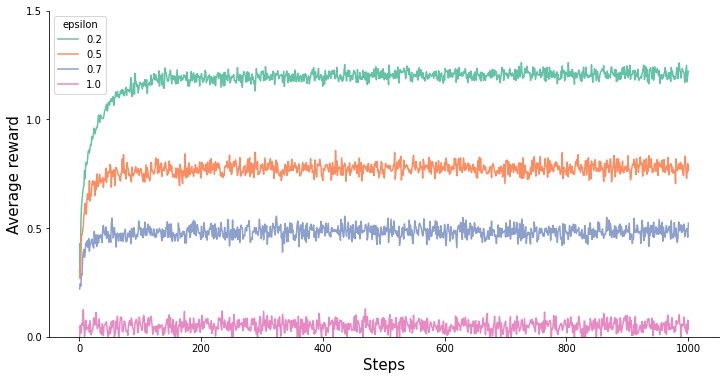

In [ ]:
# Plot average reward across different runs, for each value of epsilon
fig, ax = plt.subplots(1, 1, figsize=(12,6))
sns.lineplot(data=data, x="timestep", y="rewards", hue='epsilon', ci=None, ax=ax, palette='Set2')
ax.set_ylim([0, 1.5])
ax.set_yticks([0, 0.5, 1, 1.5])
ax.set_xlabel('Steps', fontsize=15)
ax.set_ylabel('Average reward', fontsize=15)
sns.despine();

So the optimal value is not that high... I'll try again

In [ ]:
# Run simulation many times for different values of epsilon
n_runs = 2000

# Initialize output list
D = []

#changing epsilon to be greater than 0.1  
for e in [0.125, 0.15, .175, .2]:

  print('epsilon = '  + str(e))

  for r in np.arange(n_runs): 

    print('simulation #: ' + str(r+1))

    n_timesteps = 1000
    params = {
      'n_arms': 10,
      'means': np.array([0.5, -0.9, 1.5, 0.7, 1.3, -1.5, -0.3, -1, 0.9, -0.7]),
      'sds': np.ones((n_arms,)) * 0.5,
      'epsilon': e 
    }

    _, _, sim_output = run_simulation(n_timesteps, params)

    # convert to dataframe and append to list
    d = pd.DataFrame(sim_output)
    d.insert(0, 'run', r+1)
    d.insert(1, 'epsilon', e)
    D.append(d)

data = pd.concat(D, ignore_index=True)

Streaming output truncated to the last 5000 lines.
simulation #: 1003
simulation #: 1004
simulation #: 1005
simulation #: 1006
simulation #: 1007
simulation #: 1008
simulation #: 1009
simulation #: 1010
simulation #: 1011
simulation #: 1012
simulation #: 1013
simulation #: 1014
simulation #: 1015
simulation #: 1016
simulation #: 1017
simulation #: 1018
simulation #: 1019
simulation #: 1020
simulation #: 1021
simulation #: 1022
simulation #: 1023
simulation #: 1024
simulation #: 1025
simulation #: 1026
simulation #: 1027
simulation #: 1028
simulation #: 1029
simulation #: 1030
simulation #: 1031
simulation #: 1032
simulation #: 1033
simulation #: 1034
simulation #: 1035
simulation #: 1036
simulation #: 1037
simulation #: 1038
simulation #: 1039
simulation #: 1040
simulation #: 1041
simulation #: 1042
simulation #: 1043
simulation #: 1044
simulation #: 1045
simulation #: 1046
simulation #: 1047
simulation #: 1048
simulation #: 1049
simulation #: 1050
simulation #: 1051
simulation #: 1052

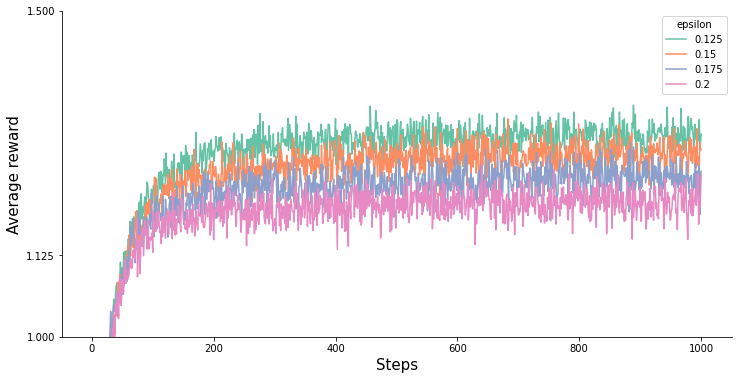

In [ ]:
# Plot average reward across different runs, for each value of epsilon
fig, ax = plt.subplots(1, 1, figsize=(12,6))
sns.lineplot(data=data, x="timestep", y="rewards", hue='epsilon', ci=None, ax=ax, palette='Set2')
ax.set_ylim([1, 1.5])
ax.set_yticks([1.0, 1.125, 1.5])
ax.set_xlabel('Steps', fontsize=15)
ax.set_ylabel('Average reward', fontsize=15)
sns.despine();

.125 is the best! I was correct. Diminishing returns begin around .15 and get worse from there. 

# Question 2: 
In lecture, we learned that another way to encourage exploration is by allowing agents to start with optimistic initial values. Check that this is the case by comparing the performance of a wildly optimistic agent that starts with  𝑄𝑡=5  and greedily selects actions, to that of a realistic agent which explores randomly with probability  ϵ=0.1  (hint, see plot from lecture).

- optimistic so q doesnt start at 0, it starts at 5, then probability of explore > exploit (greedy) so A = argmax Q(a)
- realistic q =0 to start, explores more so epsilon = 0.1 and a = random action


In [ ]:
class OptimisticEnvironment(object):
  
  """Class for the multiarmed bandit environment.

  Parameters
  ----------
  k : int
      Number of arms.
  mu : array, float, shape(k, )
      Mean for each arm.
  sigma : array, float, shape(k, )
      Standard deviation for each arm. 

  """

  def __init__(self, k, mu, sigma):

    """Constructor for the Environment class
    This function runs every time we create an instance of the class Environment
    To learn more about how constructors work: https://www.udacity.com/blog/2021/11/__init__-in-python-an-overview.html"""

    # "self" is just a convention that binds the attributes and methods of a class with the arguments of a given instance

    self.k = k          # number of arms
    self.mu = mu        # mean of reward distribution for each arm
    self.sigma = sigma  # standard deviation of reward distribution for each arm
    self.t = 0          # initialize timestep
    
    if self.mu.shape[0] is not k:
      raise Warning("Mean vector shape does not match number of arms")

    if self.sigma.shape[0] is not k:
      raise Warning("Sigma vector shape does not match number of arms")

  def visualize(self, style):

    # this method lets us visualize the structure of the environment
    # in the multiarmed bandit case, this consists of the reward distribution for each arm 

    # visualize as Gaussian densities
    if style == 1:
      
      x = np.arange(-5, 5, 0.001)

      for i in np.arange(self.k):
        plt.plot(x, norm.pdf(x, self.mu[i], self.sigma[i]), label='μ: ' + str(self.mu[i]) + ', σ: ' + str(self.sigma[i]))

      plt.legend()
      plt.xlabel('Reward distribution')
      plt.ylabel('Density')

    # draw many samples from each distribution and plot histograms
    if style == 2: 

      # initialize output list 
      bandit = []   # which bandit we're drawing from
      samples = []  # samples we drew

      # iterate over each bandit
      for i in np.arange(self.k):
        
        n_samples = 1000

        # create bandit index
        b = list(np.ones((n_samples, )) * (i+1))

        # draw samples
        s = list(np.random.normal(self.mu[i], self.sigma[i], n_samples))
  
        # add to lists  
        bandit = bandit + b
        samples = samples + s

      # create pandas dataframe from dictionary
      # background on dictionaries: https://www.w3schools.com/python/python_dictionaries.asp
      # background on dataframes: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html 
      df = pd.DataFrame({'bandit': list(map(int, bandit)), 
                         'samples': samples})
      
      # use seaborn to plot distributions
      # background on seaborn: https://seaborn.pydata.org/index.html
      sns.violinplot(data=df, x="bandit", y="samples")
      
      plt.xlabel('Action')
      plt.ylabel('Reward distribution')

  def step(self, action):

    # the step method takes as input an action and changes the environment
    # in the bandit case, the environment responds with a reward

     # draw reward
    reward = np.random.normal(self.mu[action-1], self.sigma[action-1], 1)[0]

    # increment timestep
    self.t = self.t + 1

    # comment the next line in if you want to print the time step
    # print('timestep: ' + str(self.t))

    return reward

#environment class does not need to change for question 2

In [ ]:
class OptimisticAgent(object):
  """Class for the e-greedy agent.

  Parameters
  ----------
  epsilon : float, range (0, 1)
      Epsilon probability of exploration.

  q_init : array, int, shape(k,)
    Initial value function of action

  """

  def __init__(self, env, epsilon, q_init=False):

    # initialize action space
    self.action_space = np.arange(env.k) + 1

    # initialize parameters
    self.eps = epsilon
    
    # initialize Q-values and action counters
    if q_init: # check if initial q-values were provided 
      # self.q = q_init
      self.q = np.ones((env.k, ))*q_init     
    else:   
      self.q = np.zeros((env.k, ))
    
    # initialize action counter
    self.action_counter = np.zeros((env.k, ))  

  def policy(self):

    # for now, you can think of the policy method as encoding how 
    # an agent selects actions.
    # in the epsilon-greedy case, the agent has an internal representation
    # of the value of each action. its policy is to pick the action with the 
    # highest value with probability 1-epsilon and explore a random action with 
    # probabilty epsilon.  

    # generate random number between 0 and 1.
    # this draws from a uniform distribution, so we have an equal probability
    # of generating any real number between 0 and 1.
    p = np.random.rand()

    # select action
    if (p < self.eps): # is the number we drew is smaller than epsilon? 
      action = np.random.choice(env.k)+1 # random action
    else: 
      action = np.argmax(self.q)+1 # action with highest q-value     
    
    return action

  def update(self, action, reward, verbose=False):

    # the update method encodes how the agent learns from its actions. 
    # it takes as input the action and reward.
  
    # update action counter
    self.action_counter[action-1] = self.action_counter[action-1] + 1

    # update value of selected action in proportion to the difference between the 
    # current reward and the previous value, times a step size 
    # equal to the inverse of how many times the agent selected that action in the past.
    # in other words, the step size will be smaller the more we select that action. 
    self.q[action-1] = self.q[action-1] + 1/self.action_counter[action-1] * (reward - self.q[action-1])

    if verbose == True: 
      print(self.q)

In [ ]:
def Optimistic_run_simulation(n_timesteps, params, verbose=False):

  """Function for running one simulation of the bandit problem.
  It specifies how the environment and agent interact over the course
  of multiple timesteps.

  Parameters
  ----------

  n_timesteps: int
      How many timesteps to run the simulation for

  params : dictionary containing parameters of the simulation 

      Environment parameters
      n_arms: int
        Number of arms.
      means: array, float, shape(n_arms, )
        Means for each arm.
      sds: array, float, shape(n_arms, )
        Standard deviations for each arm.
      
      Agent parameters
      epsilon: float, range (0, 1)
        Epsilon probability of exploration.
      q_init : array, int, shape(k,)
        Initial value function of action

  verbose: flag for printing some output

  Returns
  ----------

  sim_output: dictionary containing simulation output

      actions: array, int, shape(n_timesteps, )
        Action that the agent took on each timestep.

      rewards: array, float, shape(n_timesteps, )
        Rewards that the agent received on each timestep.

      optimal_action: array, boolean, shape(n_timestep, )
        Indicator vector that tells us if the agent took the best possible action.
  """

  # make environment (10-arm testbed with varying means and same standard deviation)
  env = OptimisticEnvironment(params['k'], params['means'], params['sds'])

  # initialize agent 
  agent = OptimisticAgent(env, params['epsilon'], params['q_init'])

  # initialize output lists
  A = [] # action taken at each timestep
  R = [] # rewards on each timestep
  OA = [] # was the optimal action taken at each timestep? 

  # loop for given number of timesteps
  for t in np.arange(n_timesteps):

    # agent selects action
    action = agent.policy()

    # environment responds with a reward
    reward = env.step(action)

    # record action and reward
    A.append(action)
    R.append(reward)

    # record whether the agent took the optimal action
    optimal_action = np.argmax(params['means'])+1
    OA.append(action == optimal_action)
    
    if verbose: 
      print('action: ' + str(action))
      print('reward: ' + str(reward))

    agent.update(action, reward, verbose=False)

  # record output in dictionary
  sim_output = {
      'timestep': np.arange(n_timesteps)+1,
      'actions': np.array(A),
      'rewards': np.array(R),
      'optimal_action': np.array(OA)
  }

  return env, agent, sim_output

In [ ]:
#run simulation many times 
n_runs = 2000

# Initialize output list
O = []

#running simulation for Q(t) = 5 and epsilon = 0 (greedy)

for r in np.arange(n_runs): 

  print('simulation #: ' + str(r+1))
  n_timesteps = 1000
  params = {
    'k': 10,
    'means': np.array([0.5, -0.9, 1.5, 0.7, 1.3, -1.5, -0.3, -1, 0.9, -0.7]),
    'sds': np.ones((10,)) * 0.5,
    'epsilon': 0, #makes greedy agent  
    'q_init' : 5
  }

  _, _, sim_output = Optimistic_run_simulation(n_timesteps, params)

    # convert to dataframe and append to list
  o = pd.DataFrame(sim_output)
  o.insert(0, 'run', r+1)
  o.insert(1, 'epsilon', params['epsilon'])
  o.insert(2, 'q_init', params['q_init'])
  O.append(o)

optimistic = pd.concat(O, ignore_index=True)

simulation #: 1
simulation #: 2
simulation #: 3
simulation #: 4
simulation #: 5
simulation #: 6
simulation #: 7
simulation #: 8
simulation #: 9
simulation #: 10
simulation #: 11
simulation #: 12
simulation #: 13
simulation #: 14
simulation #: 15
simulation #: 16
simulation #: 17
simulation #: 18
simulation #: 19
simulation #: 20
simulation #: 21
simulation #: 22
simulation #: 23
simulation #: 24
simulation #: 25
simulation #: 26
simulation #: 27
simulation #: 28
simulation #: 29
simulation #: 30
simulation #: 31
simulation #: 32
simulation #: 33
simulation #: 34
simulation #: 35
simulation #: 36
simulation #: 37
simulation #: 38
simulation #: 39
simulation #: 40
simulation #: 41
simulation #: 42
simulation #: 43
simulation #: 44
simulation #: 45
simulation #: 46
simulation #: 47
simulation #: 48
simulation #: 49
simulation #: 50
simulation #: 51
simulation #: 52
simulation #: 53
simulation #: 54
simulation #: 55
simulation #: 56
simulation #: 57
simulation #: 58
simulation #: 59
simula

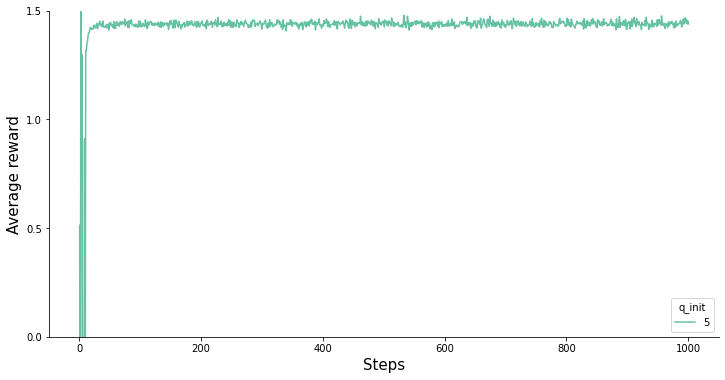

In [ ]:
# Plot average reward across different runs
fig, ax = plt.subplots(1, 1, figsize=(12,6))
sns.lineplot(data=optimistic, x="timestep", y="rewards", hue='q_init', ci=None, ax=ax, palette='Set2')
ax.set_ylim([1, 1.5])
ax.set_yticks([0, 0.5, 1.0, 1.5])
ax.set_xlabel('Steps', fontsize=15)
ax.set_ylabel('Average reward', fontsize=15)
sns.despine();

In [ ]:
# Run simulation many times for different values of epsilon
n_runs = 2000

# Initialize output list
NG = []

#running single simulation for Q(t) = 0 and epsilon = 0.1 (not greedy)

for r in np.arange(n_runs): 

  print('simulation #: ' + str(r+1))
  n_timesteps = 1000
  params = {
    'k': 10,
    'means': np.array([0.5, -0.9, 1.5, 0.7, 1.3, -1.5, -0.3, -1, 0.9, -0.7]),
    'sds': np.ones((10,)) * 0.5,
    'epsilon': 0.1, #makes not greedy agent  
    'q_init' : 0
  }

  _, _, sim_output = Optimistic_run_simulation(n_timesteps, params)

    # convert to dataframe and append to list
  ng = pd.DataFrame(sim_output)
  ng.insert(0, 'run', r+1)
  ng.insert(1, 'epsilon', params['epsilon'])
  ng.insert(2, 'q_init', params['q_init'])
  NG.append(ng)

notgreedy = pd.concat(NG, ignore_index=True)

simulation #: 1
simulation #: 2
simulation #: 3
simulation #: 4
simulation #: 5
simulation #: 6
simulation #: 7
simulation #: 8
simulation #: 9
simulation #: 10
simulation #: 11
simulation #: 12
simulation #: 13
simulation #: 14
simulation #: 15
simulation #: 16
simulation #: 17
simulation #: 18
simulation #: 19
simulation #: 20
simulation #: 21
simulation #: 22
simulation #: 23
simulation #: 24
simulation #: 25
simulation #: 26
simulation #: 27
simulation #: 28
simulation #: 29
simulation #: 30
simulation #: 31
simulation #: 32
simulation #: 33
simulation #: 34
simulation #: 35
simulation #: 36
simulation #: 37
simulation #: 38
simulation #: 39
simulation #: 40
simulation #: 41
simulation #: 42
simulation #: 43
simulation #: 44
simulation #: 45
simulation #: 46
simulation #: 47
simulation #: 48
simulation #: 49
simulation #: 50
simulation #: 51
simulation #: 52
simulation #: 53
simulation #: 54
simulation #: 55
simulation #: 56
simulation #: 57
simulation #: 58
simulation #: 59
simula

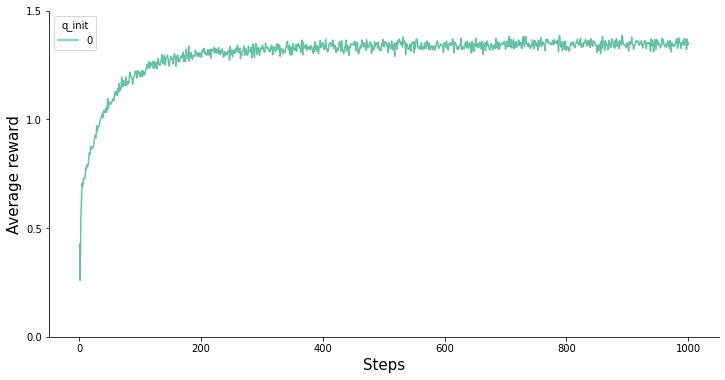

In [ ]:
# plotting data for initial q value = 0
fig, ax = plt.subplots(1, 1, figsize=(12,6))
sns.lineplot(data=notgreedy, x="timestep", y="rewards", hue='q_init', ci=None, ax=ax, palette='Set2')
ax.set_ylim([1, 1.5])
ax.set_yticks([0, 0.5, 1.0, 1.5])
ax.set_xlabel('Steps', fontsize=15)
ax.set_ylabel('Average reward', fontsize=15)
sns.despine();

In [ ]:
#re-running the different agents to compare 
# Run simulation many times for different values of epsilon
n_runs = 2000

# Initialize output list
ONG = []

for q in [0, 5]: 

  if q == 5: 
    e = 0
  else:
    e = 0.1

  print('e = '  + str(e))
  print('q init = '  + str(q))
  
  for r in np.arange(n_runs): 

    print('simulation #: ' + str(r+1))

    n_timesteps = 1000
    params = {
      'k': 10,
      'means': np.array([0.5, -0.9, 1.5, 0.7, 1.3, -1.5, -0.3, -1, 0.9, -0.7]),
      'sds': np.ones((n_arms,)) * 0.5,
      'epsilon': e,
      'q_init': q 
    }

    _, _, sim_output = Optimistic_run_simulation(n_timesteps, params)

    # convert to dataframe and append to list
    ong = pd.DataFrame(sim_output)
    ong.insert(0, 'run', r+1)
    ong.insert(1, 'epsilon', params['epsilon'])
    ong.insert(2, 'q_init', params['q_init'])
    ONG.append(ong)

optimistic_notgreedy = pd.concat(ONG, ignore_index=True)

e = 0.1
q init = 0
simulation #: 1
simulation #: 2
simulation #: 3
simulation #: 4
simulation #: 5
simulation #: 6
simulation #: 7
simulation #: 8
simulation #: 9
simulation #: 10
simulation #: 11
simulation #: 12
simulation #: 13
simulation #: 14
simulation #: 15
simulation #: 16
simulation #: 17
simulation #: 18
simulation #: 19
simulation #: 20
simulation #: 21
simulation #: 22
simulation #: 23
simulation #: 24
simulation #: 25
simulation #: 26
simulation #: 27
simulation #: 28
simulation #: 29
simulation #: 30
simulation #: 31
simulation #: 32
simulation #: 33
simulation #: 34
simulation #: 35
simulation #: 36
simulation #: 37
simulation #: 38
simulation #: 39
simulation #: 40
simulation #: 41
simulation #: 42
simulation #: 43
simulation #: 44
simulation #: 45
simulation #: 46
simulation #: 47
simulation #: 48
simulation #: 49
simulation #: 50
simulation #: 51
simulation #: 52
simulation #: 53
simulation #: 54
simulation #: 55
simulation #: 56
simulation #: 57
simulation #: 58
simu

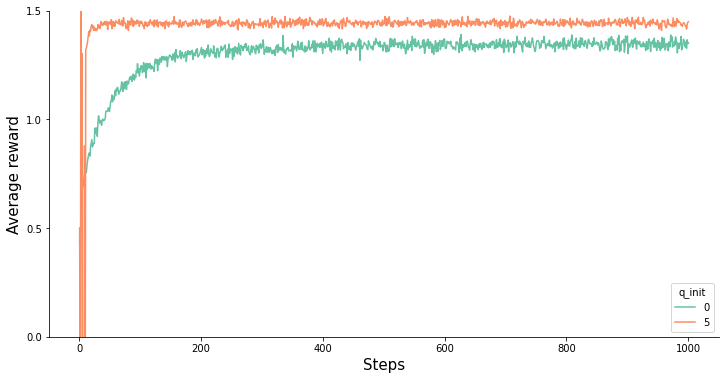

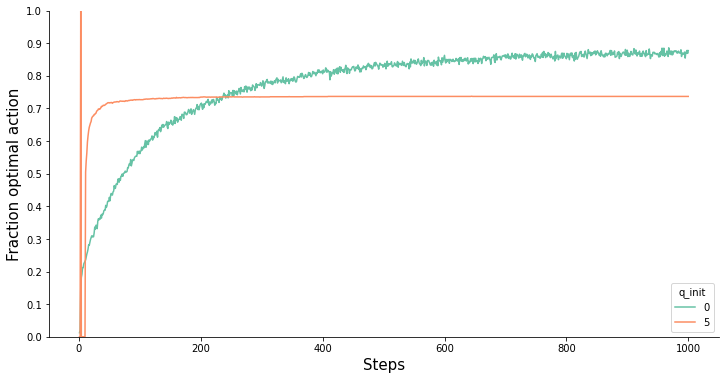

In [ ]:
# Plot average reward across different runs, for each value of epsilon
fig, ax = plt.subplots(1, 1, figsize=(12,6))
sns.lineplot(data=optimistic_notgreedy, x="timestep", y="rewards", hue='q_init', ci=None, ax=ax, palette='Set2')
ax.set_ylim([0, 1.5])
ax.set_yticks([0, 0.5, 1, 1.5])
ax.set_xlabel('Steps', fontsize=15)
ax.set_ylabel('Average reward', fontsize=15)
sns.despine();

# Plot fraction correct across different runs, for each value of epsilon 
fig, ax = plt.subplots(1, 1, figsize=(12,6))
sns.lineplot(data=optimistic_notgreedy, x="timestep", y="optimal_action", hue='q_init', ci=None, ax=ax, palette='Set2')
ax.set_ylim([0, 1])
ax.set_yticks(np.arange(11)/10)
ax.set_xlabel('Steps', fontsize=15)
ax.set_ylabel('Fraction optimal action', fontsize=15)
sns.despine();

An agent that is highly optimistic (initial value function is high, not zero) and greedy (always chooses action with highest value) will perform a multi-armed bandit task nearly the same as an agent that is not optimistic and not greedy (initial value = 0, epsilon = 0.1). In 2000 simulations of these agents we see that their average reward amounts and fraction of optimal actions converges to be very similar after 1000 timesteps. This is because the optimistic greedy agent will explore often because the agent is often disappointed at the result of its actions initially. A realistic, non-greedy agent has more of an explore/exploit balance with a more accurate measure of value of its actions. 

# Question 3: 
Modify the agent's policy to add uncertainty-driven exploration using the UCB algorithm from lecture. How does the agent's performance change as a function of the  𝑐  parameter?

- c parameter controls degree of exploration (confidence level of exploration) so large c promotes exploration and small c promotes exploitation

In [ ]:
class UCBEnvironment(object):
  
  """Class for the multiarmed bandit environment.

  Parameters
  ----------
  k : int
      Number of arms.
  mu : array, float, shape(k, )
      Mean for each arm.
  sigma : array, float, shape(k, )
      Standard deviation for each arm. 

  """

  def __init__(self, k, mu, sigma):

    self.k = k          # number of arms
    self.mu = mu        # mean of reward distribution for each arm
    self.sigma = sigma  # standard deviation of reward distribution for each arm
    self.t = 0          # initialize timestep
    
    if self.mu.shape[0] is not k:
      raise Warning("Mean vector shape does not match number of arms")

    if self.sigma.shape[0] is not k:
      raise Warning("Sigma vector shape does not match number of arms")

  def visualize(self, style):

    if style == 1:
      
      x = np.arange(-5, 5, 0.001)

      for i in np.arange(self.k):
        plt.plot(x, norm.pdf(x, self.mu[i], self.sigma[i]), label='μ: ' + str(self.mu[i]) + ', σ: ' + str(self.sigma[i]))

      plt.legend()
      plt.xlabel('Reward distribution')
      plt.ylabel('Density')

    if style == 2: 

      bandit = []   
      samples = []  

      for i in np.arange(self.k):
        
        n_samples = 1000

        b = list(np.ones((n_samples, )) * (i+1))

        s = list(np.random.normal(self.mu[i], self.sigma[i], n_samples))
  
        bandit = bandit + b
        samples = samples + s

      df = pd.DataFrame({'bandit': list(map(int, bandit)), 
                         'samples': samples})
      

      sns.violinplot(data=df, x="bandit", y="samples")
      
      plt.xlabel('Action')
      plt.ylabel('Reward distribution')

  def step(self, action):

    reward = np.random.normal(self.mu[action-1], self.sigma[action-1], 1)[0]

    self.t = self.t + 1

    return reward

#environment does not need to change

In [ ]:
class UCBAgent(object):
  """Class for the e-greedy agent.

  Parameters:
  -------------
  c_level : 
    controls degree of exploration (confidence level)

  """

  def __init__(self, env, c_level):

    # initialize action space
    self.action_space = np.arange(env.k) + 1

  
    self.q = np.zeros((env.k, ))
    
    # initialize action counter
    self.action_counter = np.zeros((env.k, ))  

    self.c_level = c_level

  def policy(self): #updating policy for UCB function
    #agent now selects actions according to UCB, which selects actions 
    #by measuring their potential to be optimal, not randomly.

    # select action
    action = np.argmax(self.q + self.c_level*np.sqrt((np.log(env.t)/self.action_counter)))+1 # non-greedy optimal action
    return action

  def update(self, action, reward, verbose=False):

    # the update method encodes how the agent learns from its actions. 
    # it takes as input the action and reward.
  
    # update action counter
    self.action_counter[action-1] = self.action_counter[action-1] + 1

    # update value of selected action in proportion to the difference between the 
    # current reward and the previous value, times a step size 
    # equal to the inverse of how many times the agent selected that action in the past.
    # in other words, the step size will be smaller the more we select that action. 
    self.q[action-1] = self.q[action-1] + 1/self.action_counter[action-1] * (reward - self.q[action-1])

    if verbose == True: 
      print(self.q)

# must edit agent to change policy to UCB. 

In [ ]:
def UCB_run_simulation(n_timesteps, params, verbose=False):


  # make environment (10-arm testbed with varying means and same standard deviation)
  env = UCBEnvironment(params['k'], params['means'], params['sds'])

  # initialize agent 
  agent = UCBAgent(env, params['c_level'])

  # initialize output lists
  A = [] # action taken at each timestep
  R = [] # rewards on each timestep
  OA = [] # was the optimal action taken at each timestep? 

  # loop for given number of timesteps
  for t in np.arange(n_timesteps):

    # agent selects action
    action = agent.policy()

    # environment responds with a reward
    reward = env.step(action)

    # record action and reward
    A.append(action)
    R.append(reward)

    # record whether the agent took the optimal action
    optimal_action = np.argmax(params['means'])+1
    OA.append(action == optimal_action)
    
    if verbose: 
      print('action: ' + str(action))
      print('reward: ' + str(reward))

    agent.update(action, reward, verbose=False)

  # record output in dictionary
  sim_output = {
      'timestep': np.arange(n_timesteps)+1,
      'actions': np.array(A),
      'rewards': np.array(R),
      'optimal_action': np.array(OA)
  }

  return env, agent, sim_output

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in sqrt


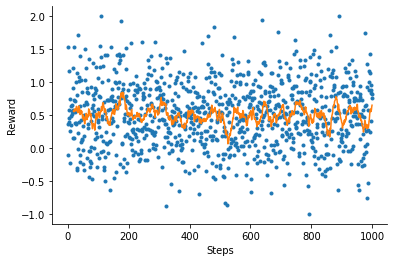

In [ ]:
# Run simulation once
n_timesteps = 1000
params = {
    'k': 10,
    'means': np.array([0.5, -0.9, 1.5, 0.7, 1.3, -1.5, -0.3, -1, 0.9, -0.7]),
    'sds': np.ones((10,)) * 0.5,
    'c_level' : 2
}


_, _, sim_output = UCB_run_simulation(n_timesteps, params)
df = pd.DataFrame(sim_output['rewards'])

# Plot reward at each timestep
plt.plot(np.arange(n_timesteps), sim_output['rewards'], '.')
plt.plot(np.arange(n_timesteps), df.rolling(20).mean(), '-')
plt.xlabel('Steps')
plt.ylabel('Reward')
sns.despine();

In [ ]:
# Run simulation many times for different values of epsilon
n_runs = 2000

# Initialize output list
UCB = []

for c in [.5, 1, 2, 3]: 
  
  for r in np.arange(n_runs): 

    print('simulation #: ' + str(r+1))

    n_timesteps = 1000
    params = {
      'k': 10,
      'means': np.array([0.5, -0.9, 1.5, 0.7, 1.3, -1.5, -0.3, -1, 0.9, -0.7]),
      'sds': np.ones((n_arms,)) * 0.5,
      'c_level': c 
    }

    _, _, sim_output = UCB_run_simulation(n_timesteps, params)

    # convert to dataframe and append to list
    ucb = pd.DataFrame(sim_output)
    ucb.insert(0, 'run', r+1)
    ucb.insert(1, 'c_level', params['c_level'])
  UCB.append(ucb)

ucb_test = pd.concat(UCB, ignore_index=True)



simulation #: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in sqrt


Streaming output truncated to the last 5000 lines.
simulation #: 1001
simulation #: 1002
simulation #: 1003
simulation #: 1004
simulation #: 1005
simulation #: 1006
simulation #: 1007
simulation #: 1008
simulation #: 1009
simulation #: 1010
simulation #: 1011
simulation #: 1012
simulation #: 1013
simulation #: 1014
simulation #: 1015
simulation #: 1016
simulation #: 1017
simulation #: 1018
simulation #: 1019
simulation #: 1020
simulation #: 1021
simulation #: 1022
simulation #: 1023
simulation #: 1024
simulation #: 1025
simulation #: 1026
simulation #: 1027
simulation #: 1028
simulation #: 1029
simulation #: 1030
simulation #: 1031
simulation #: 1032
simulation #: 1033
simulation #: 1034
simulation #: 1035
simulation #: 1036
simulation #: 1037
simulation #: 1038
simulation #: 1039
simulation #: 1040
simulation #: 1041
simulation #: 1042
simulation #: 1043
simulation #: 1044
simulation #: 1045
simulation #: 1046
simulation #: 1047
simulation #: 1048
simulation #: 1049
simulation #: 1050

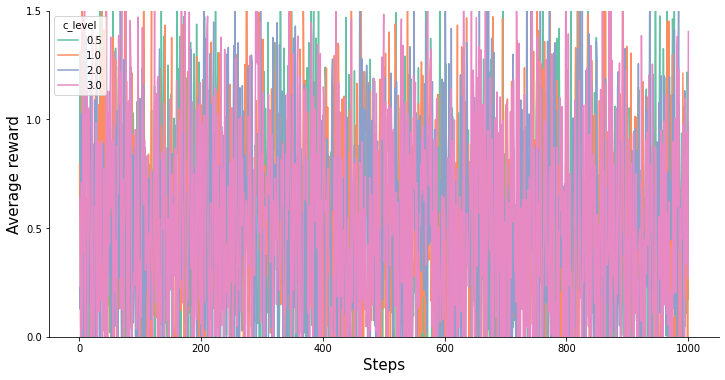

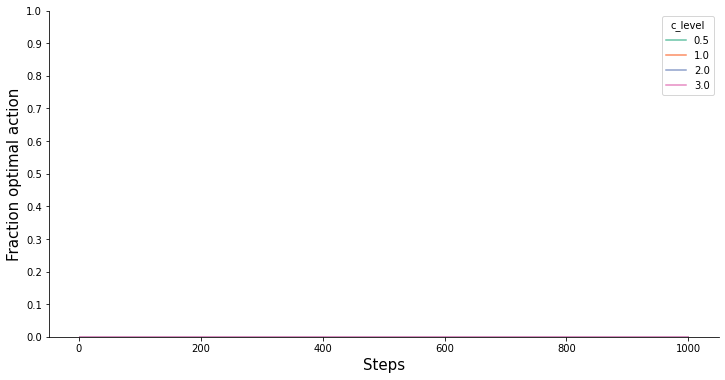

In [ ]:
# Plot average reward across different runs, for each value of epsilon
fig, ax = plt.subplots(1, 1, figsize=(12,6))
sns.lineplot(data=ucb_test, x="timestep", y="rewards", hue='c_level', ci=None, ax=ax, palette='Set2')
ax.set_ylim([0, 1.5])
ax.set_yticks([0, 0.5, 1, 1.5])
ax.set_xlabel('Steps', fontsize=15)
ax.set_ylabel('Average reward', fontsize=15)
sns.despine();

# Plot fraction correct across different runs, for each value of epsilon 
fig, ax = plt.subplots(1, 1, figsize=(12,6))
sns.lineplot(data=ucb_test, x="timestep", y="optimal_action", hue='c_level', ci=None, ax=ax, palette='Set2')
ax.set_ylim([0, 1.0])
ax.set_yticks(np.arange(11)/10)
ax.set_xlabel('Steps', fontsize=15)
ax.set_ylabel('Fraction optimal action', fontsize=15)
sns.despine();

# Question 4: 
Modify the Environment class to implement the 4-armed bandit task described in Addicott et al. (2017). Confirm by visualizing the reward structure.

- values vary based on random walk
- choices are made using softmax function

In [ ]:
rew = np.array([0.5,0.7,1.0,0.2])

np.random.seed(314)
rew[0]

0.5

In [ ]:
class RandomWalkEnvironment(object):
  
  """Class for the multiarmed bandit environment.

  Parameters
  ----------
  k : int
      Number of arms. Should be 4
  rew_init : array, float, shape(k, )
      Initial reward value for each arm - random walk goes from this initial point
  """

  def __init__(self, rew_init):

    self.k = 3         # number of arms
    self.t = 0          # initialize timestep
    self.rew_init = rew_init #array of initial reward values for each arm (always 4)

  def step(self, action): #action comes from agent class! which arm chosen

    np.random.seed(314) #setting seed to make 4 arms random walks always the same

    #info for random walks
    step_n = 1000
    step_set = [-1, 0, 1]
    step_shape = (step_n,)

    
    #arm 1
    if action == 0:
      origin = self.rew_init[0]
      steps = np.random.choice(a=step_set, size=step_shape)
      path = np.concatenate([origin, steps]).cumsum(0)
      path_arm1 = np.concatenate([origin, steps]).cumsum(0)
      reward = np.array(path_arm1[self.t],)


    #arm 2
    elif action == 1: 
      origin = self.rew_init[1]
      steps = np.random.choice(a=step_set, size=step_shape)
      path_arm2 = np.concatenate([origin, steps]).cumsum(0)
      reward = np.array(path_arm2[self.t],)

    #arm 3
    elif action == 2:
      origin = self.rew_init[2]
      steps = np.random.choice(a=step_set, size=step_shape)
      path_arm3 = np.concatenate([origin, steps]).cumsum(0)
      reward = np.array(path_arm3[self.t],)

    #arm 4
    elif action == 3:
      origin = self.rew_init[3]
      steps = np.random.choice(a=step_set, size=step_shape)
      path_arm4 = np.concatenate([origin, steps]).cumsum(0)
      reward = np.array(path_arm4[self.t],)

    # increment timestep
    self.t = self.t + 1

    return reward
    
  def visualize(self):

    # initialize output list 
    bandit = []   # which bandit we're drawing from
    samples = []  # samples we drew

    # iterate over each bandit
    for i in np.arange(self.k):
      
      n_samples = 1000

      if i == 0:
        bandit.append('Arm 1')
        samples.append(list(self.path_arm1))
      elif i == 1:
        bandit.append('Arm 2')
        samples.append(list(self.path_arm2))
      elif i == 2:
        bandit.append('Arm 3')
        samples.append(list(self.path_arm3))
      elif i == 3:
        bandit.append('Arm 4')
        samples.append(list(self.path_arm4))
      
    df = pd.DataFrame({'bandit': list(map(int, bandit)), 
                        'samples': samples})
    
    sns.violinplot(data=df, x="bandit", y="samples")
    
    plt.xlabel('Action')
    plt.ylabel('Reward distribution')

  

In [ ]:
rew_init = np.array([0.2, 0.5, 0.7, 1.0])
env = RandomWalkEnvironment(rew_init)
agent = Agent(env,0.1)

env.visualize()


AttributeError: ignored

In [ ]:
#run simulation function
def run_simulation(n_timesteps, params, verbose=False):

  """Function for running one simulation of the bandit problem.
  It specifies how the environment and agent interact over the course
  of multiple timesteps.

  Parameters
  ----------

  n_timesteps: int
      How many timesteps to run the simulation for

  params : dictionary containing parameters of the simulation 

      Environment parameters
      rew_init: array, float, shape(n_arms, )
        starting reward value for each arm
      
      Agent parameters
      epsilon: float, range (0, 1)
        Epsilon probability of exploration.

  verbose: flag for printing some output

  Returns
  ----------

  sim_output: dictionary containing simulation output

      actions: array, int, shape(n_timesteps, )
        Action that the agent took on each timestep.

      rewards: array, float, shape(n_timesteps, )
        Rewards that the agent received on each timestep.

      optimal_action: array, boolean, shape(n_timestep, )
        Indicator vector that tells us if the agent took the best possible action.
  """

  # make environment (10-arm testbed with varying means and same standard deviation)
  env = RandomWalkEnvironment(params['rew_init'])

  # initialize agent 
  agent = Agent(env, params['epsilon'])

  # initialize output lists
  A = [] # action taken at each timestep
  R = [] # rewards on each timestep
  OA = [] # was the optimal action taken at each timestep? 

  # loop for given number of timesteps
  for t in np.arange(n_timesteps):

    # agent selects action
    action = agent.policy()

    # environment responds with a reward
    reward = env.step(action)

    # record action and reward
    A.append(action)
    R.append(reward)
    
    if verbose: 
      print('action: ' + str(action))
      print('reward: ' + str(reward))

    agent.update(action, reward, verbose=False)

  # record output in dictionary
  sim_output = {
      'timestep': np.arange(n_timesteps)+1,
      'actions': np.array(A),
      'rewards': np.array(R),
  }

  return env, agent, sim_output

In [ ]:
#run simulation many times 
n_runs = 2000

# Initialize output list
fourarm = []

#running simulation for Q(t) = 5 and epsilon = 0 (greedy)

for r in np.arange(n_runs): 

  print('simulation #: ' + str(r+1))
  n_timesteps = 1000
  params = {
    'rew_init': np.array([0.2,0.5,0.7,1.0]),
    'epsilon': 0.1, #makes not greedy agent  
  }

  _, _, sim_output = run_simulation(n_timesteps, params)

    # convert to dataframe and append to list
  data = pd.DataFrame(sim_output)
  data.insert(0, 'run', r+1)
  data.insert(1, 'epsilon', params['epsilon'])
  fourarm.append(data)

#i tried!!!

simulation #: 1


ValueError: ignored